# Monocular Depth Estimation Using U-Net and MobileNetV3 on Jetson TX2 NX Devices

This model aims for monocular depth estimation using a U-Net architecture with a MobileNetV3 as the encoder. The model is trained on the NYU Depth V2 Dataset.

The model are built using the pytorch and then will be converted to ONNX then to a TensorRT engine for inference on the Jetson TX2 NX device.

The model is trained using the Adam optimizer with a learning rate of 0.0001 (Can be changed). The model is trained using the mean squared error loss function.

For more information on the model, please refer to the following paper: https://arxiv.org/pdf/2004.04572.pdf

An Aditional information can be accessed in the following link: https://github.com/alinstein/Depth_estimation, https://www.kaggle.com/code/muhammadhafil/monocular-depth-estimation and https://www.kaggle.com/code/harits/indoor-depth-estimation-u-net

The dataset used for training can be found in the following link: https://diode-dataset.org/ or https://www.kaggle.com/datasets/soumikrakshit/nyu-depth-v2

In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import albumentations as A
from PIL import Image
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import gc
import time

# torch
import torch
import torchvision
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.cuda.amp import GradScaler, autocast
# Metrics
from torchmetrics.image import StructuralSimilarityIndexMeasure as SSIM
from torchmetrics.regression import MeanSquaredError as MSE
from torchmetrics.regression import MeanAbsoluteError as MAE
from torchmetrics.collections import MetricCollection

# warnings
import warnings
warnings.filterwarnings("ignore")

# sklearn
from sklearn.model_selection import train_test_split

# Convert
import torch.onnx
import onnx
import tensorrt as trt

# Class
from NYUDataset import Dataset
from Model import Model

In [2]:
# Check for how many GPUs are available
print("GPU Available: ", torch.cuda.is_available())
print("Number of GPUs: ", torch.cuda.device_count())

GPU Available:  True
Number of GPUs:  1


In [3]:
torch.zeros(1).cuda()

tensor([0.], device='cuda:0')

# Hyperparameters

In [4]:
# Hyperparameters
BATCH_SIZE = 32
EPOCHS = 10
LEARNING_RATE = 0.0001
HEIGHT = 192
WIDTH = 256

# Dataset Preparation

In [5]:
train_csv = "./data/nyu2_train.csv"
train_ims_path = "./data/nyu2_train_images/"
base_path = "./"

In [6]:
df = pd.read_csv(train_csv, header=None)
df[0] = df[0].map(lambda x: os.path.join(base_path, x))
df[1] = df[1].map(lambda x: os.path.join(base_path, x))

df.head()

0  \
0   ./data/nyu2_train/living_room_0038_out/37.jpg   
1  ./data/nyu2_train/living_room_0038_out/115.jpg   
2    ./data/nyu2_train/living_room_0038_out/6.jpg   
3   ./data/nyu2_train/living_room_0038_out/49.jpg   
4  ./data/nyu2_train/living_room_0038_out/152.jpg   

                                                1  
0   ./data/nyu2_train/living_room_0038_out/37.png  
1  ./data/nyu2_train/living_room_0038_out/115.png  
2    ./data/nyu2_train/living_room_0038_out/6.png  
3   ./data/nyu2_train/living_room_0038_out/49.png  
4  ./data/nyu2_train/living_room_0038_out/152.png

In [7]:
train_df, val_df = train_test_split(df,test_size=0.1,shuffle=True)
val_df, test_df = train_test_split(val_df, test_size=0.1,shuffle=True)
train_df.reset_index(drop=True,inplace=True)
val_df.reset_index(drop=True,inplace=True)
test_df.reset_index(drop=True,inplace=True)
len(train_df),len(val_df), len(test_df)

(45619, 4562, 507)

# Visualize the Depth Map

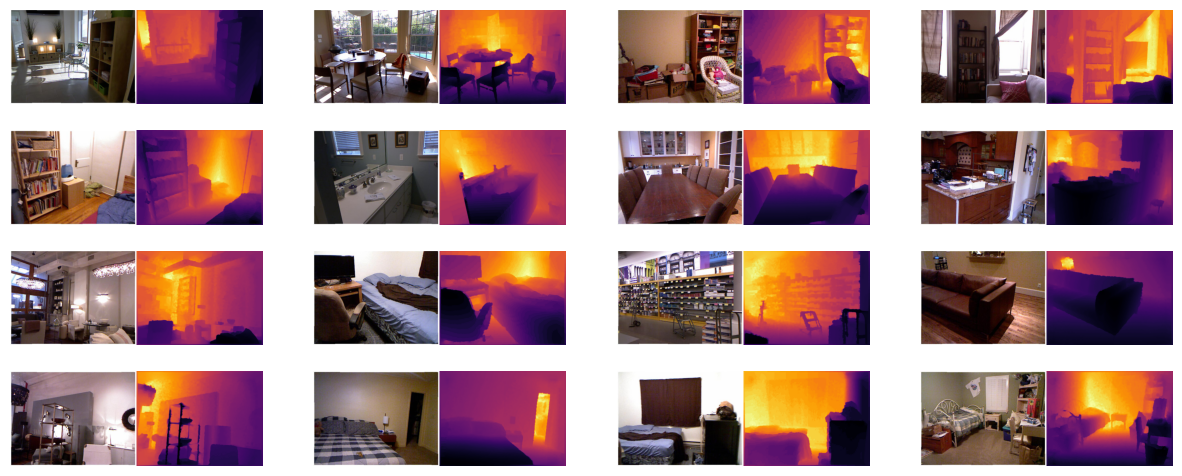

In [8]:
def colored_depthmap(depth, d_min=None, d_max=None,cmap=plt.cm.inferno):
    if d_min is None:
        d_min = np.min(depth)
    if d_max is None:
        d_max = np.max(depth)
    depth_relative = (depth - d_min) / (d_max - d_min)
    return 255 * cmap(depth_relative)[:,:,:3] # H, W, C

def merge_into_row(input, depth_target):
    input = np.array(input)
    depth_target = np.squeeze(np.array(depth_target))

    d_min = np.min(depth_target)
    d_max = np.max(depth_target)
    depth_target_col = colored_depthmap(depth_target, d_min, d_max)
    img_merge = np.hstack([input, depth_target_col])
    
    return img_merge

plt.figure(figsize=(15, 6))
for i, idx in enumerate(np.random.randint(0,len(df),(16,))):
    ax = plt.subplot(4, 4, i + 1)
    image = Image.open(df.iloc[idx,0]).convert('RGB')
    mask = Image.open(df.iloc[idx,1]).convert('L')
    image_viz = merge_into_row(
        image,mask
    )
    plt.imshow(image_viz.astype("uint8"))
    plt.axis("off")

# Dataset

In [9]:
sample_tfms = [
    A.HorizontalFlip(),
    A.GaussNoise(p=0.2),
    A.OneOf([
        A.MotionBlur(p=.3),
        A.MedianBlur(blur_limit=3, p=0.3),
        A.Blur(blur_limit=3, p=0.5),
    ], p=0.3),
    A.RGBShift(),
    A.RandomBrightnessContrast(),
    A.RandomResizedCrop(384, 384),
    A.ColorJitter(),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.3, rotate_limit=45, p=0.5),
    A.HueSaturationValue(p=0.3),
]
train_tfms = A.Compose([
    *sample_tfms,
    A.Resize(HEIGHT,WIDTH),
    A.Normalize(always_apply=True),
    ToTensorV2()
])
valid_tfms = A.Compose([
    A.Resize(HEIGHT,WIDTH),
    A.Normalize(always_apply=True),
    ToTensorV2()
])

In [10]:
train_ds = Dataset(train_df,train_tfms)
val_ds = Dataset(val_df,valid_tfms)
test_ds = Dataset(test_df, valid_tfms)
len(train_ds), len(val_ds), len(test_ds)

(45619, 4562, 507)

In [11]:
train_dl = torch.utils.data.DataLoader(train_ds,shuffle=True,batch_size=64)
val_dl = torch.utils.data.DataLoader(val_ds,shuffle=False,batch_size=64)
test_dl = torch.utils.data.DataLoader(test_ds, shuffle=True, batch_size=4)
len(train_dl), len(val_dl), len(test_dl)

(713, 72, 127)

# Loss Function and Metrics
The loss function used are SSIM and MSE. The SSIM is used to measure the similarity between two images, while the MSE is used to measure the difference between two images. 

The metrics used are RMSE, MAE, and SSIM. The RMSE is used to measure the difference between the predicted depth map and the ground truth depth map. The MAE is used to measure the difference between the predicted depth map and the ground truth depth map. The SSIM is used to measure the similarity between the predicted depth map and the ground truth depth map.

In [12]:
class UnNormalize(torchvision.transforms.Normalize):
    def __init__(self,*args,**kwargs):
        mean=(0.485, 0.456, 0.406)
        std=(0.229, 0.224, 0.225)
        new_mean = [-m/s for m,s in zip(mean,std)]
        new_std = [1/s for s in std]
        super().__init__(new_mean, new_std, *args, **kwargs)

@torch.no_grad()
def plot_vals(imgs, preds, targets,n=4,figsize=(6,2),title=''):
    plt.figure(figsize=figsize,dpi=150)
    r = 2 if n == 4 else 8
    c = 2
    for i,idx in enumerate(np.random.randint(0,imgs.size(0),(n,))):
        ax = plt.subplot(r,c,i + 1)
        img,pred,gt = imgs[idx], preds[idx], targets[idx]
        img = UnNormalize()(img)*255.
        img,pred,gt = img.permute(1,2,0).numpy(), pred.permute(1,2,0).numpy(), gt.permute(1,2,0).numpy()
        pred = colored_depthmap(np.squeeze(pred))
        gt = colored_depthmap(np.squeeze(gt))
        image_viz = np.hstack([img,pred,gt])
        plt.imshow(image_viz.astype("uint8"))
        plt.axis("off")
    title = f'{title}\nimage/target/prediction' if len(title)!=0 else 'image/target/prediction'
    plt.suptitle(title)
    plt.show()

In [13]:
# Check for GPU availability
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(DEVICE)

# Send the model to the device
model = Model().to(DEVICE)

cuda:0


In [14]:
# Your metrics code remains unchanged
metrics = MetricCollection([
  MSE(),
  MAE(),
  SSIM(data_range=1.0)
]).to(DEVICE)

train_metrics = metrics.clone()
val_metrics = metrics.clone()

logs = pd.DataFrame()
logs[['loss_train','loss_val','ssim_train','ssim_val','mse_train','mse_val', 'mae_train','mae_val']] = None

loss_fn = torch.nn.MSELoss()
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE / 25, weight_decay=0.02)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=LEARNING_RATE, epochs=EPOCHS, steps_per_epoch=(len(train_dl)))

# (Optional) Uncomment the below lines for mixed precision training
scaler = GradScaler()


# Training

Training Started...


Epochs:   0% 0/10 [00:00<?, ?it/s]
Training:   0% 0/713 [00:00<?, ?it/s]
Loss: 0.1508:   0% 0/713 [00:04<?, ?it/s]
Loss: 0.1508:   0% 1/713 [00:04<54:44,  4.61s/it]
Loss: 0.3093:   0% 1/713 [00:06<54:44,  4.61s/it]
Loss: 0.3093:   0% 2/713 [00:06<38:43,  3.27s/it]
Loss: 0.4586:   0% 2/713 [00:09<38:43,  3.27s/it]
Loss: 0.4586:   0% 3/713 [00:09<36:29,  3.08s/it]
Loss: 0.6134:   0% 3/713 [00:12<36:29,  3.08s/it]
Loss: 0.6134:   1% 4/713 [00:12<36:32,  3.09s/it]
Loss: 0.7576:   1% 4/713 [00:15<36:32,  3.09s/it]
Loss: 0.7576:   1% 5/713 [00:15<34:29,  2.92s/it]
Loss: 0.9094:   1% 5/713 [00:17<34:29,  2.92s/it]
Loss: 0.9094:   1% 6/713 [00:17<32:34,  2.76s/it]
Loss: 1.0593:   1% 6/713 [00:20<32:34,  2.76s/it]
Loss: 1.0593:   1% 7/713 [00:20<30:29,  2.59s/it]
Loss: 1.2043:   1% 7/713 [00:22<30:29,  2.59s/it]
Loss: 1.2043:   1% 8/713 [00:22<29:07,  2.48s/it]
Loss: 1.3573:   1% 8/713 [00:24<29:07,  2.48s/it]
Loss: 1.3573:   1% 9/713 [00:24<28:53,  2.46s/it]
Loss: 1.5064:   1% 9/713 [00:27<28:

Epoch: 1/10, Loss: 3.5064, SSIM: 0.2952, MSE: 0.0487, MAE: 0.1813, BEST SSIM: 0.2952 at Epoch: 1


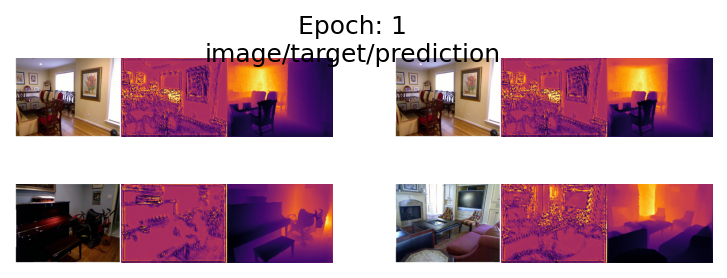

Epochs:  10% 1/10 [40:26<6:04:00, 2426.77s/it]
Training:   0% 0/713 [00:00<?, ?it/s]
Loss: 0.0413:   0% 0/713 [00:03<?, ?it/s]
Loss: 0.0413:   0% 1/713 [00:03<39:26,  3.32s/it]
Loss: 0.0862:   0% 1/713 [00:06<39:26,  3.32s/it]
Loss: 0.0862:   0% 2/713 [00:07<41:50,  3.53s/it]
Loss: 0.1308:   0% 2/713 [00:09<41:50,  3.53s/it]
Loss: 0.1308:   0% 3/713 [00:09<37:36,  3.18s/it]
Loss: 0.1771:   0% 3/713 [00:12<37:36,  3.18s/it]
Loss: 0.1771:   1% 4/713 [00:12<34:01,  2.88s/it]
Loss: 0.2167:   1% 4/713 [00:14<34:01,  2.88s/it]
Loss: 0.2167:   1% 5/713 [00:14<33:08,  2.81s/it]
Loss: 0.2616:   1% 5/713 [00:17<33:08,  2.81s/it]
Loss: 0.2616:   1% 6/713 [00:17<31:12,  2.65s/it]
Loss: 0.3024:   1% 6/713 [00:19<31:12,  2.65s/it]
Loss: 0.3024:   1% 7/713 [00:19<30:08,  2.56s/it]
Loss: 0.3455:   1% 7/713 [00:22<30:08,  2.56s/it]
Loss: 0.3455:   1% 8/713 [00:22<30:42,  2.61s/it]
Loss: 0.3887:   1% 8/713 [00:24<30:42,  2.61s/it]
Loss: 0.3887:   1% 9/713 [00:24<30:23,  2.59s/it]
Loss: 0.4341:   1% 9/71

Epoch: 2/10, Loss: 0.5783, SSIM: 0.6223, MSE: 0.0080, MAE: 0.0648, BEST SSIM: 0.6223 at Epoch: 2


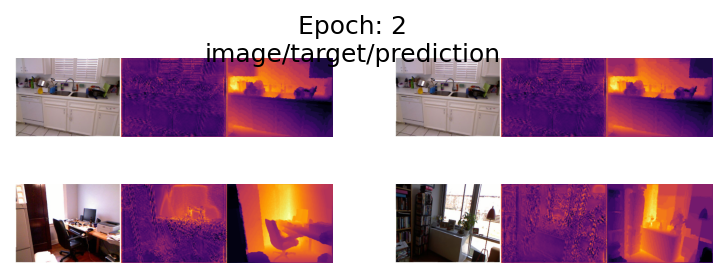

Epochs:  20% 2/10 [1:20:55<5:23:41, 2427.75s/it]
Training:   0% 0/713 [00:00<?, ?it/s]
Loss: 0.0121:   0% 0/713 [00:02<?, ?it/s]
Loss: 0.0121:   0% 1/713 [00:02<33:11,  2.80s/it]
Loss: 0.0210:   0% 1/713 [00:05<33:11,  2.80s/it]
Loss: 0.0210:   0% 2/713 [00:05<32:34,  2.75s/it]
Loss: 0.0305:   0% 2/713 [00:08<32:34,  2.75s/it]
Loss: 0.0305:   0% 3/713 [00:08<31:53,  2.69s/it]
Loss: 0.0415:   0% 3/713 [00:10<31:53,  2.69s/it]
Loss: 0.0415:   1% 4/713 [00:10<31:03,  2.63s/it]
Loss: 0.0497:   1% 4/713 [00:13<31:03,  2.63s/it]
Loss: 0.0497:   1% 5/713 [00:13<30:17,  2.57s/it]
Loss: 0.0595:   1% 5/713 [00:15<30:17,  2.57s/it]
Loss: 0.0595:   1% 6/713 [00:15<30:09,  2.56s/it]
Loss: 0.0714:   1% 6/713 [00:18<30:09,  2.56s/it]
Loss: 0.0714:   1% 7/713 [00:18<30:47,  2.62s/it]
Loss: 0.0822:   1% 7/713 [00:20<30:47,  2.62s/it]
Loss: 0.0822:   1% 8/713 [00:20<30:28,  2.59s/it]
Loss: 0.0923:   1% 8/713 [00:23<30:28,  2.59s/it]
Loss: 0.0923:   1% 9/713 [00:23<30:06,  2.57s/it]
Loss: 0.1024:   1% 9/

Epoch: 4/10, Loss: 0.3049, SSIM: 0.8142, MSE: 0.0042, MAE: 0.0461, BEST SSIM: 0.8142 at Epoch: 4


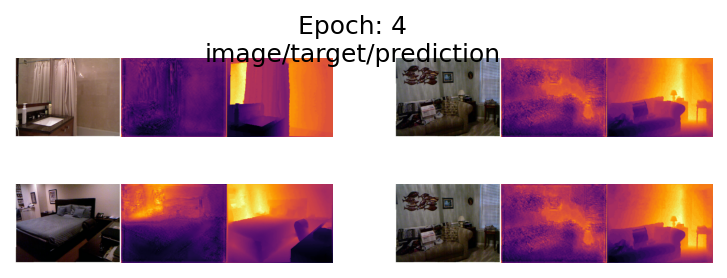

Epochs:  40% 4/10 [2:31:51<3:43:01, 2230.31s/it]
Training:   0% 0/713 [00:00<?, ?it/s]
Loss: 0.0072:   0% 0/713 [00:03<?, ?it/s]
Loss: 0.0072:   0% 1/713 [00:03<37:33,  3.16s/it]
Loss: 0.0126:   0% 1/713 [00:06<37:33,  3.16s/it]
Loss: 0.0126:   0% 2/713 [00:06<37:46,  3.19s/it]
Loss: 0.0179:   0% 2/713 [00:09<37:46,  3.19s/it]
Loss: 0.0179:   0% 3/713 [00:09<38:03,  3.22s/it]
Loss: 0.0262:   0% 3/713 [00:12<38:03,  3.22s/it]
Loss: 0.0262:   1% 4/713 [00:12<37:06,  3.14s/it]
Loss: 0.0333:   1% 4/713 [00:15<37:06,  3.14s/it]
Loss: 0.0333:   1% 5/713 [00:15<36:19,  3.08s/it]
Loss: 0.0396:   1% 5/713 [00:19<36:19,  3.08s/it]
Loss: 0.0396:   1% 6/713 [00:19<39:24,  3.34s/it]
Loss: 0.0456:   1% 6/713 [00:23<39:24,  3.34s/it]
Loss: 0.0456:   1% 7/713 [00:23<40:15,  3.42s/it]
Loss: 0.0509:   1% 7/713 [00:26<40:15,  3.42s/it]
Loss: 0.0509:   1% 8/713 [00:26<38:38,  3.29s/it]
Loss: 0.0575:   1% 8/713 [00:29<38:38,  3.29s/it]
Loss: 0.0575:   1% 9/713 [00:29<37:45,  3.22s/it]
Loss: 0.0633:   1% 9/

Epoch: 5/10, Loss: 0.3188, SSIM: 0.8398, MSE: 0.0044, MAE: 0.0472, BEST SSIM: 0.8398 at Epoch: 5


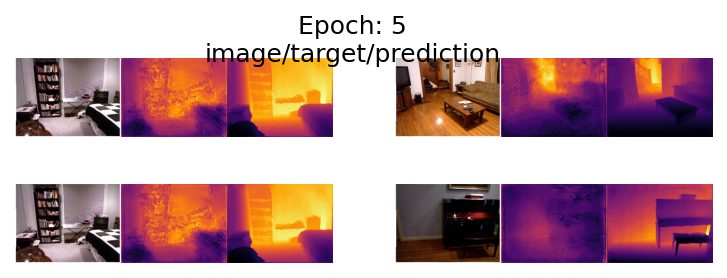

Epochs:  50% 5/10 [3:10:40<3:08:50, 2266.02s/it]
Training:   0% 0/713 [00:00<?, ?it/s]
Loss: 0.0056:   0% 0/713 [00:04<?, ?it/s]
Loss: 0.0056:   0% 1/713 [00:04<48:28,  4.09s/it]
Loss: 0.0110:   0% 1/713 [00:07<48:28,  4.09s/it]
Loss: 0.0110:   0% 2/713 [00:07<44:48,  3.78s/it]
Loss: 0.0160:   0% 2/713 [00:10<44:48,  3.78s/it]
Loss: 0.0160:   0% 3/713 [00:10<41:43,  3.53s/it]
Loss: 0.0219:   0% 3/713 [00:14<41:43,  3.53s/it]
Loss: 0.0219:   1% 4/713 [00:14<39:55,  3.38s/it]
Loss: 0.0266:   1% 4/713 [00:17<39:55,  3.38s/it]
Loss: 0.0266:   1% 5/713 [00:17<38:16,  3.24s/it]
Loss: 0.0321:   1% 5/713 [00:20<38:16,  3.24s/it]
Loss: 0.0321:   1% 6/713 [00:20<39:43,  3.37s/it]
Loss: 0.0370:   1% 6/713 [00:23<39:43,  3.37s/it]
Loss: 0.0370:   1% 7/713 [00:23<38:34,  3.28s/it]
Loss: 0.0419:   1% 7/713 [00:27<38:34,  3.28s/it]
Loss: 0.0419:   1% 8/713 [00:27<38:40,  3.29s/it]
Loss: 0.0483:   1% 8/713 [00:30<38:40,  3.29s/it]
Loss: 0.0483:   1% 9/713 [00:30<38:53,  3.31s/it]
Loss: 0.0526:   1% 9/

Epoch: 6/10, Loss: 0.2393, SSIM: 0.8600, MSE: 0.0033, MAE: 0.0399, BEST SSIM: 0.8600 at Epoch: 6


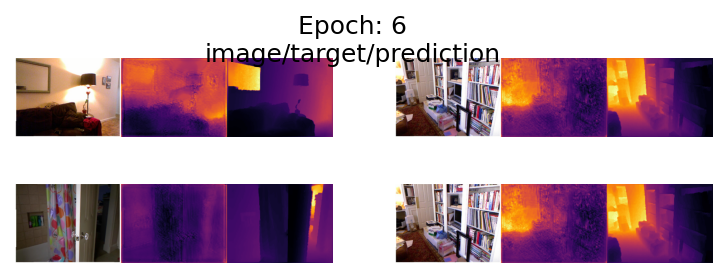

Epochs:  60% 6/10 [3:54:46<2:39:40, 2395.12s/it]
Training:   0% 0/713 [00:00<?, ?it/s]
Loss: 0.0060:   0% 0/713 [00:03<?, ?it/s]
Loss: 0.0060:   0% 1/713 [00:03<41:29,  3.50s/it]
Loss: 0.0119:   0% 1/713 [00:06<41:29,  3.50s/it]
Loss: 0.0119:   0% 2/713 [00:06<39:08,  3.30s/it]
Loss: 0.0172:   0% 2/713 [00:09<39:08,  3.30s/it]
Loss: 0.0172:   0% 3/713 [00:09<38:38,  3.27s/it]
Loss: 0.0222:   0% 3/713 [00:12<38:38,  3.27s/it]
Loss: 0.0222:   1% 4/713 [00:12<37:05,  3.14s/it]
Loss: 0.0283:   1% 4/713 [00:15<37:05,  3.14s/it]
Loss: 0.0283:   1% 5/713 [00:15<36:41,  3.11s/it]
Loss: 0.0322:   1% 5/713 [00:18<36:41,  3.11s/it]
Loss: 0.0322:   1% 6/713 [00:18<35:05,  2.98s/it]
Loss: 0.0380:   1% 6/713 [00:21<35:05,  2.98s/it]
Loss: 0.0380:   1% 7/713 [00:21<36:27,  3.10s/it]
Loss: 0.0432:   1% 7/713 [00:25<36:27,  3.10s/it]
Loss: 0.0432:   1% 8/713 [00:25<36:55,  3.14s/it]
Loss: 0.0475:   1% 8/713 [00:28<36:55,  3.14s/it]
Loss: 0.0475:   1% 9/713 [00:28<36:37,  3.12s/it]
Loss: 0.0547:   1% 9/

Epoch: 7/10, Loss: 0.2585, SSIM: 0.8703, MSE: 0.0036, MAE: 0.0413, BEST SSIM: 0.8703 at Epoch: 7


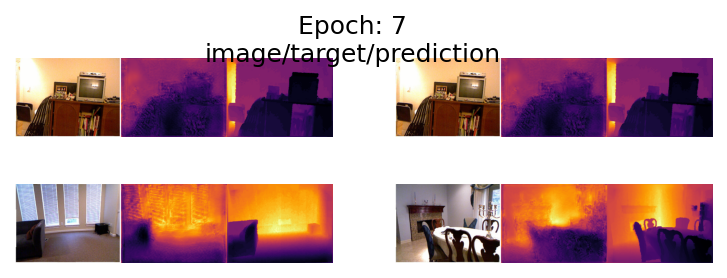

Epochs:  70% 7/10 [4:38:40<2:03:40, 2473.40s/it]
Training:   0% 0/713 [00:00<?, ?it/s]
Loss: 0.0049:   0% 0/713 [00:03<?, ?it/s]
Loss: 0.0049:   0% 1/713 [00:03<46:28,  3.92s/it]
Loss: 0.0098:   0% 1/713 [00:07<46:28,  3.92s/it]
Loss: 0.0098:   0% 2/713 [00:07<46:47,  3.95s/it]
Loss: 0.0145:   0% 2/713 [00:11<46:47,  3.95s/it]
Loss: 0.0145:   0% 3/713 [00:11<45:05,  3.81s/it]
Loss: 0.0191:   0% 3/713 [00:15<45:05,  3.81s/it]
Loss: 0.0191:   1% 4/713 [00:15<44:46,  3.79s/it]
Loss: 0.0240:   1% 4/713 [00:18<44:46,  3.79s/it]
Loss: 0.0240:   1% 5/713 [00:18<44:10,  3.74s/it]
Loss: 0.0285:   1% 5/713 [00:22<44:10,  3.74s/it]
Loss: 0.0285:   1% 6/713 [00:22<42:52,  3.64s/it]
Loss: 0.0327:   1% 6/713 [00:26<42:52,  3.64s/it]
Loss: 0.0327:   1% 7/713 [00:26<43:25,  3.69s/it]
Loss: 0.0370:   1% 7/713 [00:29<43:25,  3.69s/it]
Loss: 0.0370:   1% 8/713 [00:29<43:25,  3.70s/it]
Loss: 0.0417:   1% 8/713 [00:33<43:25,  3.70s/it]
Loss: 0.0417:   1% 9/713 [00:33<42:00,  3.58s/it]
Loss: 0.0461:   1% 9/

Epoch: 8/10, Loss: 0.2150, SSIM: 0.8762, MSE: 0.0030, MAE: 0.0376, BEST SSIM: 0.8762 at Epoch: 8


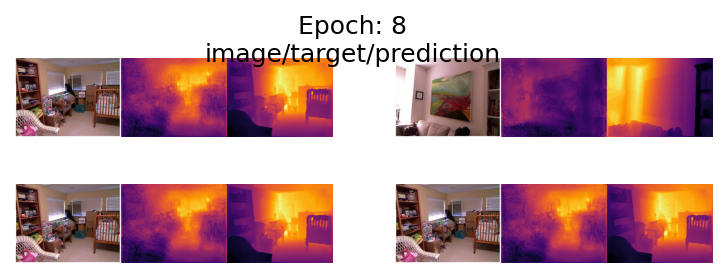

Epochs:  80% 8/10 [5:25:44<1:26:09, 2584.99s/it]
Training:   0% 0/713 [00:00<?, ?it/s]
Loss: 0.0051:   0% 0/713 [00:03<?, ?it/s]
Loss: 0.0051:   0% 1/713 [00:03<46:25,  3.91s/it]
Loss: 0.0091:   0% 1/713 [00:07<46:25,  3.91s/it]
Loss: 0.0091:   0% 2/713 [00:07<45:35,  3.85s/it]
Loss: 0.0138:   0% 2/713 [00:10<45:35,  3.85s/it]
Loss: 0.0138:   0% 3/713 [00:10<41:13,  3.48s/it]
Loss: 0.0184:   0% 3/713 [00:13<41:13,  3.48s/it]
Loss: 0.0184:   1% 4/713 [00:13<39:02,  3.30s/it]
Loss: 0.0234:   1% 4/713 [00:17<39:02,  3.30s/it]
Loss: 0.0234:   1% 5/713 [00:17<38:38,  3.27s/it]
Loss: 0.0279:   1% 5/713 [00:20<38:38,  3.27s/it]
Loss: 0.0279:   1% 6/713 [00:20<39:10,  3.32s/it]
Loss: 0.0317:   1% 6/713 [00:23<39:10,  3.32s/it]
Loss: 0.0317:   1% 7/713 [00:23<38:29,  3.27s/it]
Loss: 0.0357:   1% 7/713 [00:26<38:29,  3.27s/it]
Loss: 0.0357:   1% 8/713 [00:26<37:17,  3.17s/it]
Loss: 0.0403:   1% 8/713 [00:30<37:17,  3.17s/it]
Loss: 0.0403:   1% 9/713 [00:30<39:21,  3.35s/it]
Loss: 0.0448:   1% 9/

Epoch: 9/10, Loss: 0.2162, SSIM: 0.8765, MSE: 0.0030, MAE: 0.0376, BEST SSIM: 0.8765 at Epoch: 9


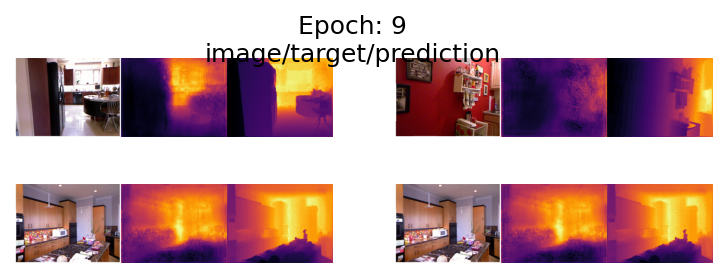

Epochs:  90% 9/10 [6:21:29<47:02, 2822.53s/it]  
Training:   0% 0/713 [00:00<?, ?it/s]
Loss: 0.0048:   0% 0/713 [00:05<?, ?it/s]
Loss: 0.0048:   0% 1/713 [00:05<1:07:42,  5.71s/it]
Loss: 0.0084:   0% 1/713 [00:10<1:07:42,  5.71s/it]
Loss: 0.0084:   0% 2/713 [00:10<1:04:42,  5.46s/it]
Loss: 0.0122:   0% 2/713 [00:16<1:04:42,  5.46s/it]
Loss: 0.0122:   0% 3/713 [00:16<1:03:34,  5.37s/it]
Loss: 0.0158:   0% 3/713 [00:21<1:03:34,  5.37s/it]
Loss: 0.0158:   1% 4/713 [00:21<1:00:57,  5.16s/it]
Loss: 0.0192:   1% 4/713 [00:26<1:00:57,  5.16s/it]
Loss: 0.0192:   1% 5/713 [00:26<1:00:41,  5.14s/it]
Loss: 0.0235:   1% 5/713 [00:31<1:00:41,  5.14s/it]
Loss: 0.0235:   1% 6/713 [00:31<1:01:47,  5.24s/it]
Loss: 0.0273:   1% 6/713 [00:37<1:01:47,  5.24s/it]
Loss: 0.0273:   1% 7/713 [00:37<1:04:38,  5.49s/it]
Loss: 0.0319:   1% 7/713 [00:43<1:04:38,  5.49s/it]
Loss: 0.0319:   1% 8/713 [00:43<1:06:11,  5.63s/it]
Loss: 0.0385:   1% 8/713 [00:50<1:06:11,  5.63s/it]
Loss: 0.0385:   1% 9/713 [00:50<1:10:09

Epoch: 10/10, Loss: 0.2086, SSIM: 0.8772, MSE: 0.0029, MAE: 0.0369, BEST SSIM: 0.8772 at Epoch: 10


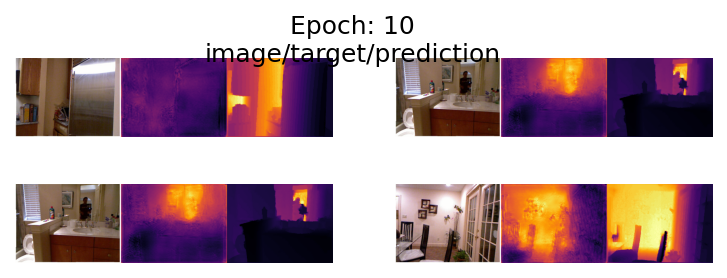

Epochs: 100% 10/10 [7:43:41<00:00, 2782.20s/it]


In [15]:
BEST_SSIM = -1e9
BEST_EPOCH = -1
FREEZE = 4

print("Training Started...")

for epoch in tqdm(range(EPOCHS), desc="Epochs"):
  model.train()
  
  if EPOCHS == FREEZE:
    model.trainable_encoder(trainable=True)
    print('training encoder and decoder both')
    
  running_loss = 0.
  train_progress = tqdm(train_dl, total=len(train_dl), leave=False, desc="Training")

  for img, mask in train_progress:        
    # (Optional) Uncomment the below lines for mixed precision training
    with autocast():
      img, mask = img.to(DEVICE), mask.to(DEVICE)
      pred = model(img)
      loss = loss_fn(pred, mask)

      scaler.scale(loss).backward()  # For mixed precision
      scaler.unscale_(optimizer)
      torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0, norm_type=2)
      scaler.step(optimizer)  # For mixed precision
      scaler.update()  # For mixed precision
      scheduler.step()
      optimizer.zero_grad()

      running_loss += loss.item()
      train_progress.set_description(f"Loss: {running_loss:.4f}")

      train_metrics(pred, mask)

      del img, mask, pred, loss

  m = train_metrics.compute()
  _ssim, _mse, _mae = m['StructuralSimilarityIndexMeasure'].cpu().item(), m['MeanSquaredError'].cpu().item(), m['MeanAbsoluteError'].cpu().item()
  logs.loc[epoch, ['loss_train','ssim_train','mse_train', 'mae_train']] = (running_loss/len(train_dl), _ssim, _mse, _mae)
  train_metrics.reset()
  model.eval()

  with torch.no_grad():
    running_loss = 0.
    val_progress = tqdm(val_dl, total=len(val_dl), leave=False, desc="Validation")

    for img, mask in val_progress:
      img, mask = img.to(DEVICE), mask.to(DEVICE)
      pred = model(img)
      loss = loss_fn(pred, mask)
      running_loss += loss.item()
      val_progress.set_description(f"Loss: {running_loss:.4f}")

      val_metrics(pred, mask)

      del img, mask, pred, loss

    m = val_metrics.compute()
    _ssim, _mse, _mae = m['StructuralSimilarityIndexMeasure'].cpu().item(), m['MeanSquaredError'].cpu().item(), m['MeanAbsoluteError'].cpu().item()
    logs.loc[epoch, ['loss_val','ssim_val','mse_val', 'mae_val']] = (running_loss/len(val_dl), _ssim, _mse, _mae)
    val_metrics.reset()

  # Save the model at every epoch
  torch.save(model.state_dict(), f"model_{epoch+1}.pt")
  
  # Save the best model based on SSIM
  if _ssim > BEST_SSIM:
    BEST_SSIM = _ssim
    BEST_EPOCH = epoch
    torch.save(model.state_dict(), "best_model.pt")

  print(f"Epoch: {epoch+1}/{EPOCHS}, Loss: {running_loss:.4f}, SSIM: {_ssim:.4f}, MSE: {_mse:.4f}, MAE: {_mae:.4f}, BEST SSIM: {BEST_SSIM:.4f} at Epoch: {BEST_EPOCH+1}")

  with torch.no_grad():
    imgs, masks = next(iter(test_dl))
    imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
    preds = model(imgs)
    plot_vals(imgs.cpu(), preds.cpu(), masks.cpu(), title=f"Epoch: {epoch+1}")

  gc.collect()
  torch.cuda.empty_cache()


In [16]:
best_sd = torch.load('UnetPlusPLus_MobilenetV3.pt')
model.load_state_dict(best_sd)

<All keys matched successfully>

100% 127/127 [00:11<00:00, 11.36it/s]


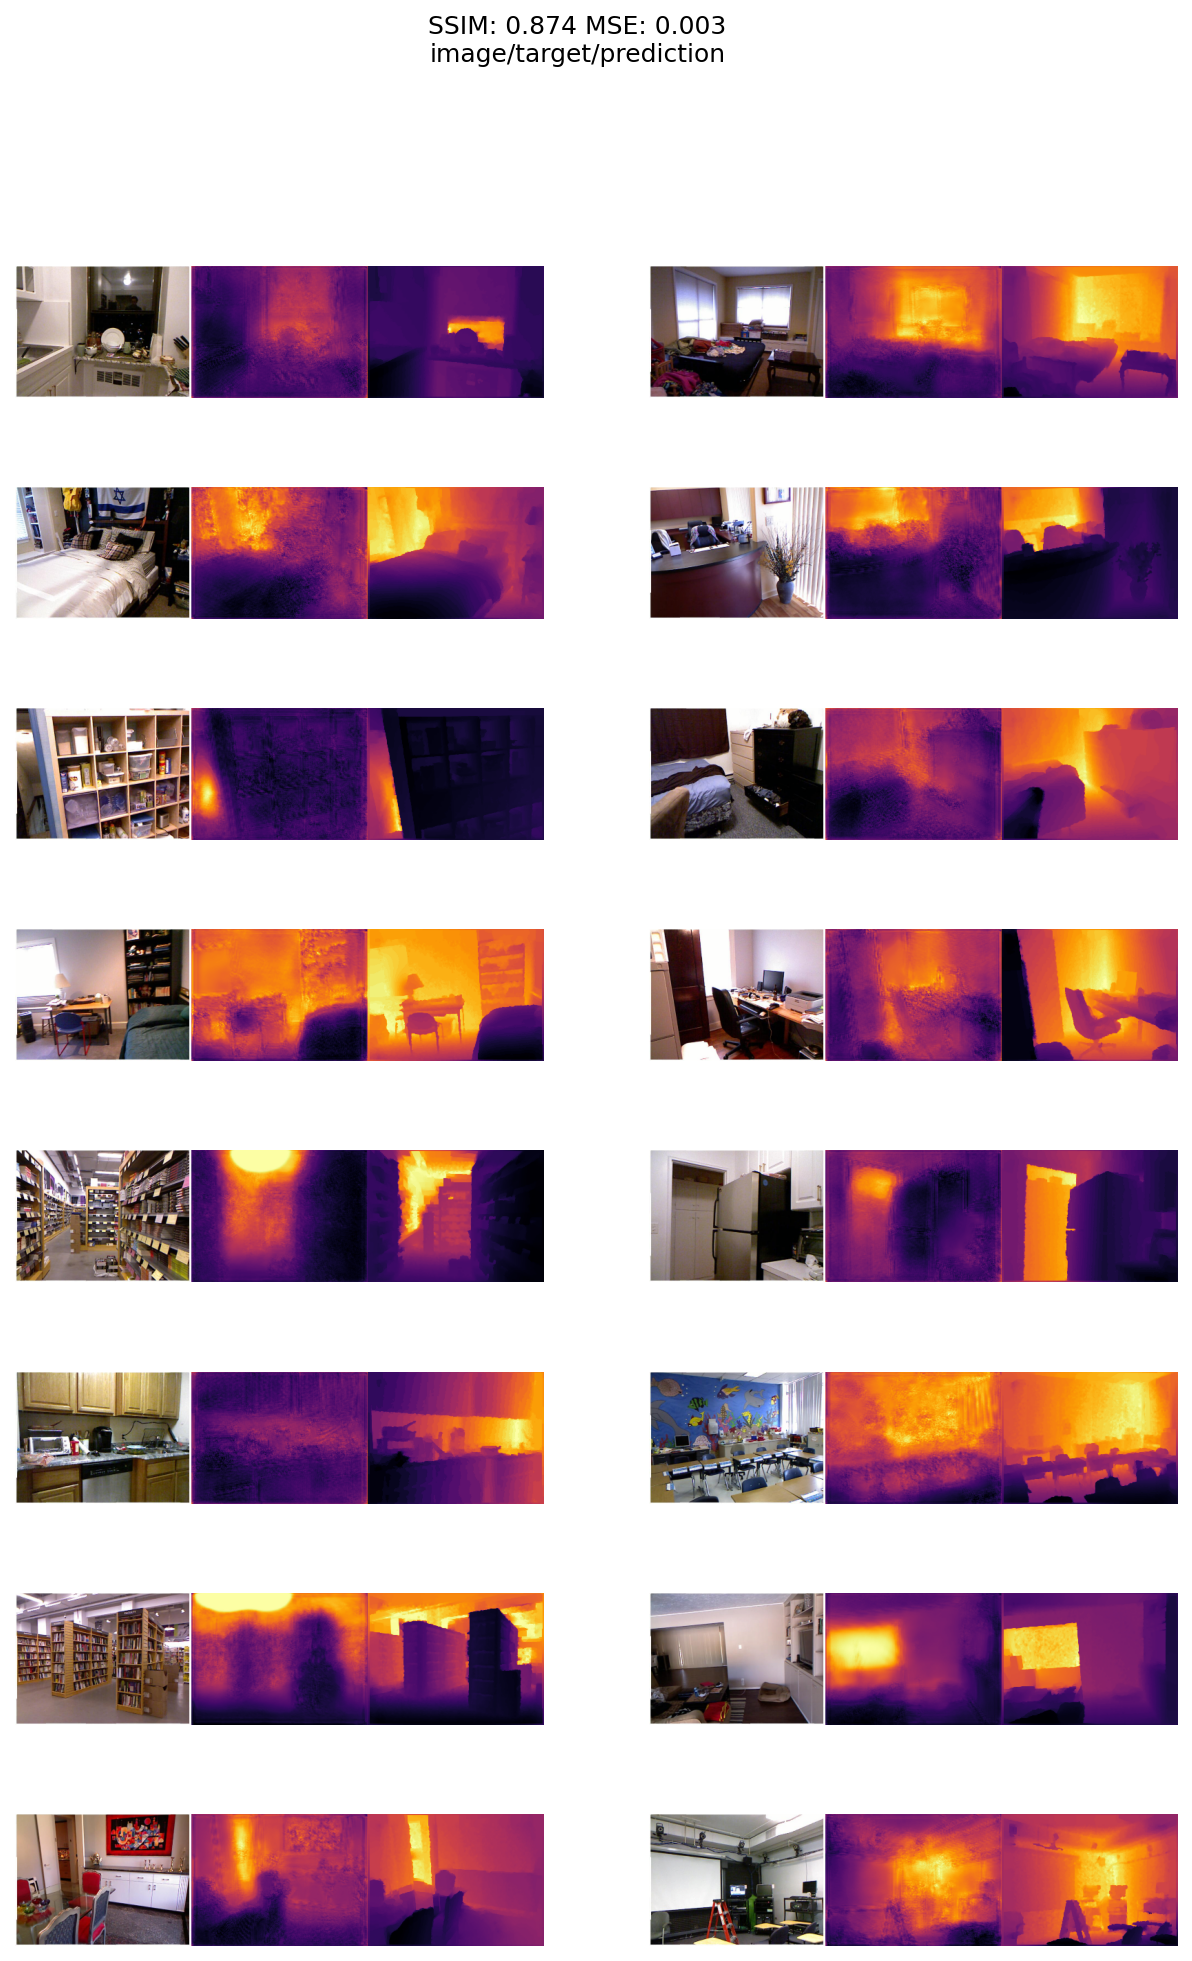

In [17]:
all_imgs, all_preds, all_targets = [], [], []
with torch.no_grad():
    with autocast():
        for img, mask in tqdm(test_dl,total=len(test_dl)):
            img, mask = img.to(DEVICE), mask.to(DEVICE)
            preds = model(img)
            all_imgs.append(img)
            all_preds.append(preds)
            all_targets.append(mask)

test_metrics = metrics.clone()
test_metrics(
    torch.vstack(all_preds),
    torch.vstack(all_targets)
)
m = test_metrics.compute()
title = f"SSIM: {m['StructuralSimilarityIndexMeasure'].cpu().item():.3f} MSE: {m['MeanSquaredError'].cpu().item():.3f}"
plot_vals(
    torch.vstack(all_imgs).cpu(),
    torch.vstack(all_preds).cpu(),
    torch.vstack(all_targets).cpu(),
    n=16,
    figsize=(10,15),
    title=title
)

In [18]:
logs

loss_train  loss_val ssim_train  ssim_val mse_train   mse_val mae_train  \
0   0.105323  0.048701   0.286007  0.295207  0.105341  0.048653  0.279361   
1    0.01923  0.008032   0.578933  0.622302  0.019233  0.008049  0.105758   
2   0.008213  0.005304    0.78413  0.760837  0.008214  0.005309  0.065546   
3   0.006538  0.004234   0.847741  0.814195  0.006538  0.004238  0.057734   
4   0.005779  0.004427   0.873835  0.839835  0.005779  0.004429  0.053747   
5   0.005248  0.003323   0.887387  0.860021  0.005248  0.003325  0.050977   
6   0.004824  0.003591   0.895382  0.870274  0.004823  0.003593  0.048749   
7   0.004565  0.002986   0.900428  0.876225  0.004565  0.002987  0.047241   
8   0.004467  0.003002   0.902348  0.876482  0.004467  0.003003  0.046543   
9    0.00437  0.002898   0.902724  0.877227   0.00437  0.002898  0.046175   

    mae_val  
0  0.181256  
1   0.06485  
2  0.052035  
3  0.046065  
4  0.047239  
5  0.039923  
6  0.041311  
7  0.037582  
8  0.037583  
9  0.036924

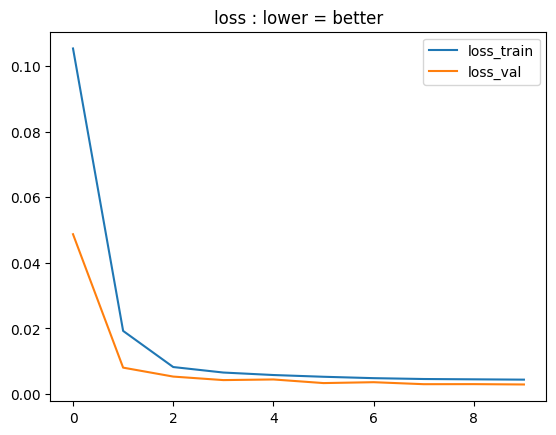

In [19]:
logs['loss_train'].plot()
logs['loss_val'].plot()
plt.title('loss : lower = better')
plt.legend()
plt.show()

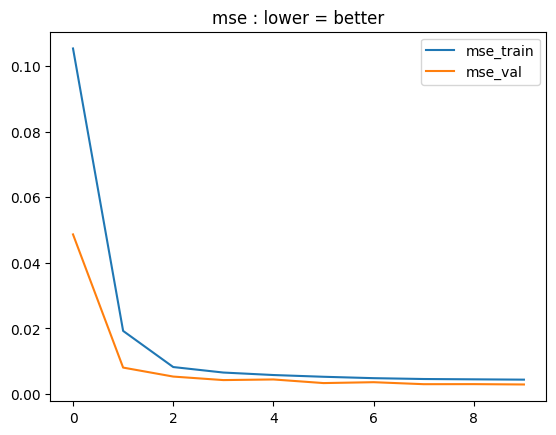

In [20]:
logs['mse_train'].plot()
logs['mse_val'].plot()
plt.title('mse : lower = better')
plt.legend()
plt.show()

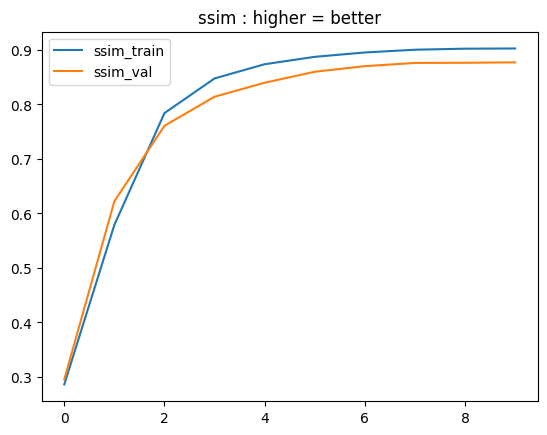

In [21]:
logs['ssim_train'].plot()
logs['ssim_val'].plot()
plt.title('ssim : higher = better')
plt.legend()
plt.show()

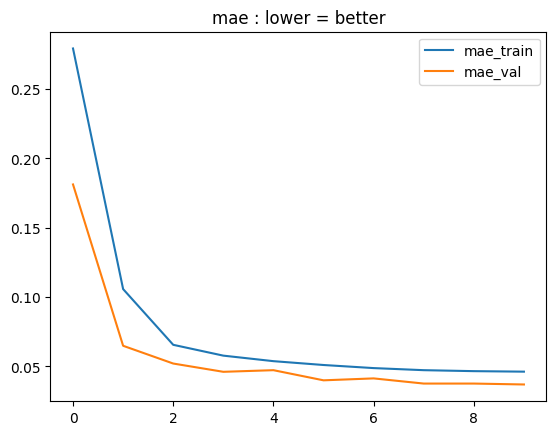

In [22]:
logs['mae_train'].plot()
logs['mae_val'].plot()
plt.title('mae : lower = better')
plt.legend()
plt.show()

In [ ]:
print("Conversion Started...")
# Convert the model to ONNX, and then to TensorRT engine
torch.onnx.export(model,torch.randn(1,3,192,256).cuda())

# Save the model as a .onnx file
onnx_model_path = "./model.onnx"
onnx_model = onnx.load(onnx_model_path)

# Check that the IR is well formed
onnx.checker.check_model(onnx_model)

# Print a human readable representation of the graph
onnx.helper.printable_graph(onnx_model.graph)